In [1]:
import numpy as np
import scipy
import pandas as pd
import math
import random
import sklearn
from nltk.corpus import stopwords
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse.linalg import svds
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Data manipulation

### Data loading

Each data file (there are 4 of them) contains below columns:

    Movie ID (as first line of each new movie record / file)
    Customer ID
    Rating (1 to 5)
    Date they gave the ratings
There is another file contains the mapping of Movie ID to the movie background like name, year of release, etc


In [4]:
# Skip date
df1 = pd.read_csv('../data/combined_data_1.txt', header = None, names = ['Cust_Id', 'Rating'], usecols = [0,1])

df1['Rating'] = df1['Rating'].astype(float)

print('Dataset 1 shape: {}'.format(df1.shape))
print('-Dataset examples-')
print(df1.iloc[::5000000, :])

Dataset 1 shape: (24058263, 2)
-Dataset examples-
          Cust_Id  Rating
0              1:     NaN
5000000   2560324     4.0
10000000  2271935     2.0
15000000  1921803     2.0
20000000  1933327     3.0


In [5]:
df2 = pd.read_csv('../data/combined_data_2.txt', header = None, names = ['Cust_Id', 'Rating'], usecols = [0,1])
df3 = pd.read_csv('../data/combined_data_3.txt', header = None, names = ['Cust_Id', 'Rating'], usecols = [0,1])
df4 = pd.read_csv('../data/combined_data_4.txt', header = None, names = ['Cust_Id', 'Rating'], usecols = [0,1])


df2['Rating'] = df2['Rating'].astype(float)
df3['Rating'] = df3['Rating'].astype(float)
df4['Rating'] = df4['Rating'].astype(float)

print('Dataset 2 shape: {}'.format(df2.shape))
print('Dataset 3 shape: {}'.format(df3.shape))
print('Dataset 4 shape: {}'.format(df4.shape))

Dataset 2 shape: (26982302, 2)
Dataset 3 shape: (22605786, 2)
Dataset 4 shape: (26851926, 2)


Now we combine datasets:

In [7]:
# load less data for speed

df = df1
df = df1.append(df2)
df = df.append(df3)
df = df.append(df4)

df.index = np.arange(0,len(df))
print('Full dataset shape: {}'.format(df.shape))
print('-Dataset examples-')
print(df.iloc[::5000000, :])

/var/folders/mk/4kptng6s0x7_vcc6jw3xmjhh0000gn/T/ipykernel_27778/2775997184.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df1.append(df2)
/var/folders/mk/4kptng6s0x7_vcc6jw3xmjhh0000gn/T/ipykernel_27778/2775997184.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df3)
/var/folders/mk/4kptng6s0x7_vcc6jw3xmjhh0000gn/T/ipykernel_27778/2775997184.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df4)


Full dataset shape: (100498277, 2)
-Dataset examples-
           Cust_Id  Rating
0               1:     NaN
5000000    2560324     4.0
10000000   2271935     2.0
15000000   1921803     2.0
20000000   1933327     3.0
25000000   1465002     3.0
30000000    961023     4.0
35000000   1372532     5.0
40000000    854274     5.0
45000000    116334     3.0
50000000    768483     3.0
55000000   1331144     5.0
60000000   1609324     2.0
65000000   1699240     3.0
70000000   1776418     4.0
75000000   1643826     5.0
80000000    932047     4.0
85000000   2292868     4.0
90000000    932191     4.0
95000000   1815101     3.0
100000000   872339     4.0


### Data reviewing

Let's give a first look on how the data spread:

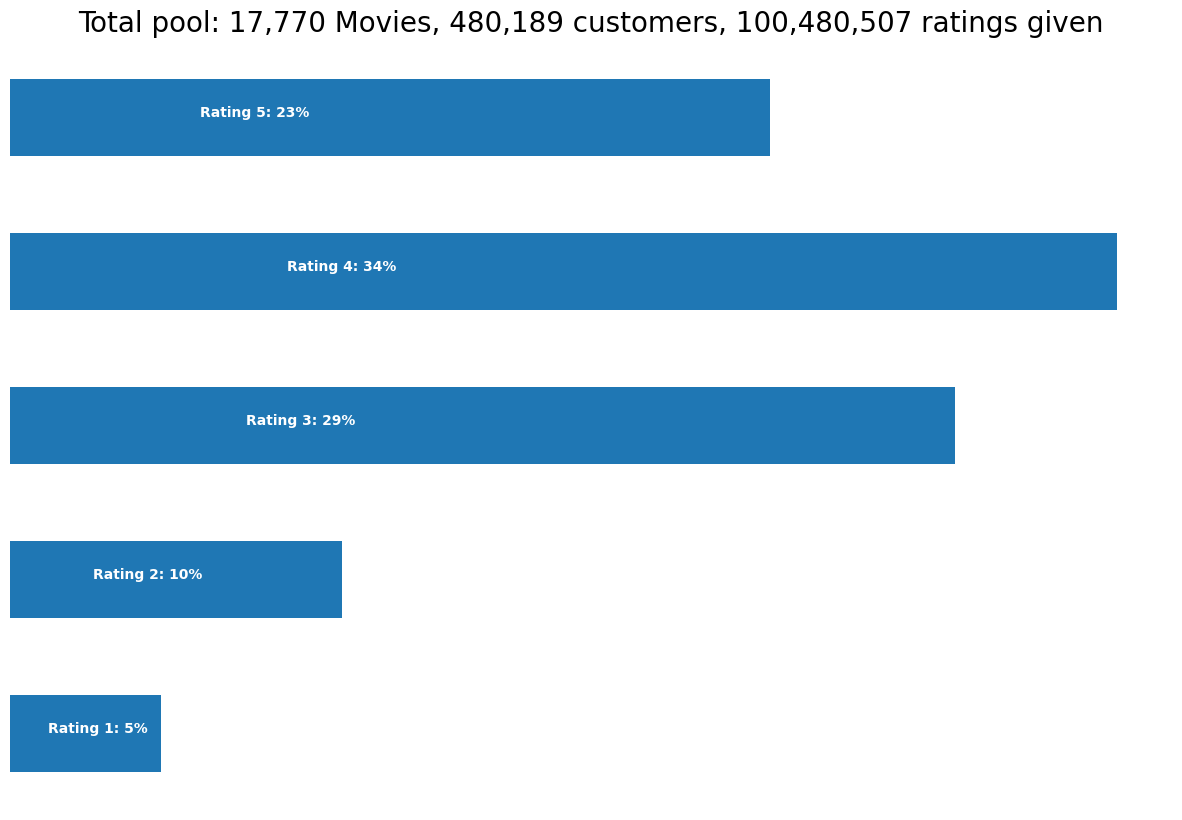

In [9]:
p = df.groupby('Rating')['Rating'].agg(['count'])

# get movie count
movie_count = df.isnull().sum()[1]

# get customer count
cust_count = df['Cust_Id'].nunique() - movie_count

# get rating count
rating_count = df['Cust_Id'].count() - movie_count

ax = p.plot(kind = 'barh', legend = False, figsize = (15,10))
plt.title('Total pool: {:,} Movies, {:,} customers, {:,} ratings given'.format(movie_count, cust_count, rating_count), fontsize=20)
plt.axis('off')

for i in range(1,6):
    ax.text(p.iloc[i-1][0]/4, i-1, 'Rating {}: {:.0f}%'.format(i, p.iloc[i-1][0]*100 / p.sum()[0]), color = 'white', weight = 'bold')

We can see that the rating tends to be relatively positive (>3). This may be due to the fact that unhappy customers tend to just leave instead of making efforts to rate. We can keep this in mind - low rating movies mean they are generally really bad

### Data cleaning

Movie ID is really a mess import! Looping through dataframe to add Movie ID column WILL make the Kernel run out of memory as it is too inefficient. We achieve my task by first creating a numpy array with correct length then add the whole array as column into the main dataframe! Let's see how it is done below:

In [10]:
df_nan = pd.DataFrame(pd.isnull(df.Rating))
df_nan = df_nan[df_nan['Rating'] == True]
df_nan = df_nan.reset_index()

movie_np = []
movie_id = 1

for i,j in zip(df_nan['index'][1:],df_nan['index'][:-1]):
    # numpy approach
    temp = np.full((1,i-j-1), movie_id)
    movie_np = np.append(movie_np, temp)
    movie_id += 1

# Account for last record and corresponding length
# numpy approach
last_record = np.full((1,len(df) - df_nan.iloc[-1, 0] - 1),movie_id)
movie_np = np.append(movie_np, last_record)

print('Movie numpy: {}'.format(movie_np))
print('Length: {}'.format(len(movie_np)))

Movie numpy: [1.000e+00 1.000e+00 1.000e+00 ... 1.777e+04 1.777e+04 1.777e+04]
Length: 100480507


In [11]:
# remove those Movie ID rows
df = df[pd.notnull(df['Rating'])]

df['Movie_Id'] = movie_np.astype(int)
df['Cust_Id'] = df['Cust_Id'].astype(int)
print('-Dataset examples-')
print(df.iloc[::5000000, :])

-Dataset examples-
           Cust_Id  Rating  Movie_Id
1          1488844     3.0         1
5000996     501954     2.0       996
10001962    404654     5.0      1962
15002876    886608     2.0      2876
20003825   1193835     2.0      3825
25004661   1899206     3.0      4661
30005496    154804     4.0      5496
35006274   2078749     5.0      6274
40007057    450763     5.0      7057
45007991    102092     3.0      7991
50009023    220298     5.0      9023
55010042    550530     5.0     10042
60011038    222570     3.0     11038
65011875   1273080     5.0     11875
70012676   2026970     5.0     12676
75013582    506044     4.0     13582
80014453    353605     2.0     14453
85015116    664606     3.0     15116
90016008   2213715     3.0     16008
95016879   1589401     5.0     16879
100017627  2314006     4.0     17627


### Data slicing

In [12]:
f = ['count','mean']

df_movie_summary = df.groupby('Movie_Id')['Rating'].agg(f)
df_movie_summary.index = df_movie_summary.index.map(int)
movie_benchmark = round(df_movie_summary['count'].quantile(0.7),0)
drop_movie_list = df_movie_summary[df_movie_summary['count'] < movie_benchmark].index

print('Movie minimum times of review: {}'.format(movie_benchmark))

df_cust_summary = df.groupby('Cust_Id')['Rating'].agg(f)
df_cust_summary.index = df_cust_summary.index.map(int)
cust_benchmark = round(df_cust_summary['count'].quantile(0.7),0)
drop_cust_list = df_cust_summary[df_cust_summary['count'] < cust_benchmark].index

print('Customer minimum times of review: {}'.format(cust_benchmark))

Movie minimum times of review: 1948.0
Customer minimum times of review: 211.0


In [13]:
print('Original Shape: {}'.format(df.shape))
df = df[~df['Movie_Id'].isin(drop_movie_list)]
df = df[~df['Cust_Id'].isin(drop_cust_list)]
print('After Trim Shape: {}'.format(df.shape))
print('-Data Examples-')
print(df.iloc[::5000000, :])

Original Shape: (100480507, 3)
After Trim Shape: (71833509, 3)
-Data Examples-
          Cust_Id  Rating  Movie_Id
696        712664     5.0         3
6959351   1973032     4.0      1395
13901827   412139     5.0      2660
20826547  1503396     4.0      3925
27788420  2417320     2.0      5121
34830730  2551271     5.0      6240
41872703  2406150     4.0      7399
48692662  1305391     2.0      8782
55551262   528496     3.0     10158
62650465   599678     2.0     11376
69655550   964493     5.0     12612
76741354   829466     5.0     13923
83765399  2255251     4.0     14953
90860581  1097827     4.0     16169
97938791  1463885     5.0     17321


In [14]:
df_p = pd.pivot_table(df,values='Rating',index='Cust_Id',columns='Movie_Id')

print(df_p.shape)

(144380, 5332)


In [233]:
print(df.tail())

           Cust_Id  Rating  Movie_Id
100497346  1428223     4.0     17769
100497349   483107     4.0     17769
100497351    77664     2.0     17769
100497352  1922916     3.0     17769
100497354  1704416     2.0     17769


In [237]:
print(df['Cust_Id'].head())

696     712664
697    1331154
698    2632461
699      44937
700     656399
Name: Cust_Id, dtype: int64


### Data mapping

In [230]:
df_title = pd.read_csv('../data/movie_titles.csv', encoding = "ISO-8859-1", header = None, names = ['Movie_Id', 'Year', 'Name'])
df_title.set_index('Movie_Id', inplace = True)
print (df_title.head(10))

            Year                          Name
Movie_Id                                      
1         2003.0               Dinosaur Planet
2         2004.0    Isle of Man TT 2004 Review
3         1997.0                     Character
4         1994.0  Paula Abdul's Get Up & Dance
5         2004.0      The Rise and Fall of ECW
6         1997.0                          Sick
7         1992.0                         8 Man
8         2004.0    What the #$*! Do We Know!?
9         1991.0      Class of Nuke 'Em High 2
10        2001.0                       Fighter


In [234]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer


2023-07-16 05:02:41.064365: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [246]:
# Step 1: Load and preprocess the data
#data = df['Rating']  # Replace with your dataset
num_users = max(df['Cust_Id'].max(), val_data['Cust_Id'].max()) + 1
num_items = max(df['Movie_Id'].max(), val_data['Movie_Id'].max()) + 1



In [247]:
# Split the data into training and validation sets
train_data, val_data = train_test_split(df, test_size=0.2)

In [252]:
# Step 1: Load and preprocess the data
#data = df['Rating']  # Replace with your dataset
num_users = max(df['Cust_Id'].max(), val_data['Cust_Id'].max()) + 1
num_items = max(df['Movie_Id'].max(), val_data['Movie_Id'].max()) + 1



In [248]:
print(train_data.head())

          Cust_Id  Rating  Movie_Id
71574922  2265561     3.0     12940
21184058   184039     5.0      3962
44296828  2442283     4.0      7828
76731395  1082923     3.0     13923
27331669   171185     4.0      5056


In [253]:
# Step 2: Data encoding
user_input = tf.keras.layers.Input(shape=(1,))
item_input = tf.keras.layers.Input(shape=(1,))


In [254]:
# Step 3: Model architecture
embedding_dim = 32
user_embedding = tf.keras.layers.Embedding(num_users, embedding_dim)(user_input)
item_embedding = tf.keras.layers.Embedding(num_items, embedding_dim)(item_input)

user_vecs = tf.keras.layers.Flatten()(user_embedding)
item_vecs = tf.keras.layers.Flatten()(item_embedding)

concatenated = tf.keras.layers.Concatenate()([user_vecs, item_vecs])

hidden_layer = tf.keras.layers.Dense(64, activation='relu')(concatenated)
output = tf.keras.layers.Dense(1)(hidden_layer)


In [257]:
# Step 4: Model training
model = tf.keras.Model(inputs=[user_input, item_input], outputs=output)
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit([train_data['Cust_Id'], train_data['Movie_Id']], train_data['Rating'], epochs=10, batch_size=1000000, verbose=1)


Epoch 1/10
58/58 [==============================] - 184s 3s/step - loss: 4.7620
Epoch 2/10
58/58 [==============================] - 222s 4s/step - loss: 0.8762
Epoch 3/10
58/58 [==============================] - 170s 3s/step - loss: 0.8116
Epoch 4/10
58/58 [==============================] - 260s 5s/step - loss: 0.8108
Epoch 5/10
58/58 [==============================] - 202s 3s/step - loss: 0.8110
Epoch 6/10
58/58 [==============================] - 209s 4s/step - loss: 0.8112
Epoch 7/10
58/58 [==============================] - 403s 7s/step - loss: 0.8114
Epoch 8/10
58/58 [==============================] - 346s 6s/step - loss: 0.8115
Epoch 9/10
58/58 [==============================] - 190s 3s/step - loss: 0.8116


In [258]:
# Step 4: Model evaluation
val_predictions = model.predict([val_data['Cust_Id'], val_data['Movie_Id']])
mse = np.mean(np.square(val_predictions.flatten() - val_data['Rating']))
print('MSE:', mse)

448960/448960 [==============================] - 514s 1ms/step
MSE: 0.8125988424636172


In [259]:
user_id = 10  # Example user ID
items = np.arange(num_items)  # All item IDs
user_ids = np.full(num_items, user_id)
predictions = model.predict([user_ids, items])
top_items = (-predictions.flatten()).argsort()[:10]  # Top 10 recommended items
print('Top 10 Recommended Items:', top_items)

556/556 [==============================] - 2s 2ms/step
Top 10 Recommended Items: [ 3456 14961  7230  7057  7833 11662  2102 14550  5103 17219]


In [267]:
top_items_names = df_title.loc[top_items]['Name'].tolist()
print('Top 10 Recommended Movies:')
for movie_name in top_items_names:
    print(movie_name)

Top 10 Recommended Movies:
Lost: Season 1
Lord of the Rings: The Return of the King: Extended Edition
The Lord of the Rings: The Fellowship of the Ring: Extended Edition
Lord of the Rings: The Two Towers: Extended Edition
Arrested Development: Season 2
The Sopranos: Season 5
The Simpsons: Season 6
The Shawshank Redemption: Special Edition
The Simpsons: Season 5
Seinfeld: Season 3


In [268]:
model.save('collaborative_filtering_model.h5')

/Users/loicsteve/anaconda3/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
